# Analiza časovne vrste podatkov Sentinel-2

Analizirali bomo časovno vrsto vegetacijskioh indeksov dobljenih iz podatkov satelita Sentinel-2. Uporabili bmo Sentinel Hub in zmogljivosti statističnih analiz časovnih vrst. Statistični servis je dobro opisan na strani [Statistical info (FIS) documentation](https://www.sentinel-hub.com/develop/documentation/api/fis-request).

In [1]:
# Knjižnice
import requests
import json
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [4]:
# Velikost grafikonov
plt.rcParams['figure.figsize'] = [12, 8]

In [5]:
# ID ključ mora biti definiran, preberemo ga iz datoteke
sentinelhub_id = 'sentinelhub.id'
f = open(sentinelhub_id,'r')
exec(f.readline())

In [6]:
if 'INSTANCE_ID' in locals():
    print("Sentinel Hub INSTANCE_ID obstaja")
    print(INSTANCE_ID)

Sentinel Hub INSTANCE_ID obstaja
f20f09f6-2bc3-46ed-8e96-438b69e367da


## Parametri za iskanje

In [8]:
# Sentinel Hub statistični servis
shub_url_base="http://services.sentinel-hub.com/ogc/fis/"
# Ločljivost 10 m
res="&RESOLUTION=10m"
# Gledamo vse posnetke
maxcc="&MAXCC=100"

## Območje

Začnemo z enostavnim poligonom.

In [9]:
crs="EPSG:4326"
geometry_fn="podatki/kranj_rupa.wkt"

In [10]:
with open(geometry_fn, 'r') as geo_file:
  geometry = geo_file.read()
time = "2015-01-01/2018-12-31"

## Poizvedba

Preberemo celotno časovno vrsto.

In [11]:
# URL za poizvedbo
shub_url = shub_url_base + INSTANCE_ID + \
    "?LAYER=NDVI-CLOUDS&STYLE=INDEX&CRS=" +  \
    crs + "&TIME=" + time + "&GEOMETRY=" + geometry + res + maxcc
shub_url

'http://services.sentinel-hub.com/ogc/fis/f20f09f6-2bc3-46ed-8e96-438b69e367da?LAYER=NDVI-CLOUDS&STYLE=INDEX&CRS=EPSG:4326&TIME=2015-01-01/2018-12-31&GEOMETRY=POLYGON ((46.25707083080395 14.361464381217955, 46.25641802763134 14.361330270767212, 46.256362390637904 14.362172484397888, 46.25658864739251 14.362376332283022, 46.25699293992463 14.363197088241579, 46.25709679440581 14.362092018127441, 46.25707083080395 14.361464381217955))&RESOLUTION=10m&MAXCC=100'

## Prenos podatkov

Časovno vrsto prenesemo v obliki JSON.

In [12]:
r=requests.get(shub_url)
contents = json.loads(r.content.decode())

In [13]:
# Ustvarimo pandas dataframe
df = json_normalize(contents['C0'])
df.head()

,basicStats.max,basicStats.mean,basicStats.min,basicStats.stDev,date
0,0.203662,0.140845,0.111700,0.018787,2018-06-30
1,0.061092,0.052540,0.045395,0.003385,2018-06-25
2,0.784255,0.688024,0.363063,0.121820,2018-06-20
3,0.363138,0.253455,0.172395,0.053041,2018-06-15
4,0.774577,0.693728,0.493108,0.049008,2018-06-10


In [14]:
# Dodamo še povprečno oblačnost v poligonu
df["clouds"] = json_normalize(contents['C1'])["basicStats.mean"]
df.head()

,basicStats.max,basicStats.mean,basicStats.min,basicStats.stDev,date,clouds
0,0.203662,0.140845,0.111700,0.018787,2018-06-30,1.000000
1,0.061092,0.052540,0.045395,0.003385,2018-06-25,1.000000
2,0.784255,0.688024,0.363063,0.121820,2018-06-20,0.000000
3,0.363138,0.253455,0.172395,0.053041,2018-06-15,0.457518
4,0.774577,0.693728,0.493108,0.049008,2018-06-10,0.000000


In [15]:
# Stolpec date pretvorimo v datum in naredimo indeks
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.set_index("date")
df.head()

,basicStats.max,basicStats.mean,basicStats.min,basicStats.stDev,clouds
date,,,,,
2018-06-30,0.203662,0.140845,0.111700,0.018787,1.000000
2018-06-25,0.061092,0.052540,0.045395,0.003385,1.000000
2018-06-20,0.784255,0.688024,0.363063,0.121820,0.000000
2018-06-15,0.363138,0.253455,0.172395,0.053041,0.457518
2018-06-10,0.774577,0.693728,0.493108,0.049008,0.000000


In [16]:
# Podatke shranimo v datoteko
df_fn = "podatki/kranj_rupa.csv"
df.to_csv(df_fn)

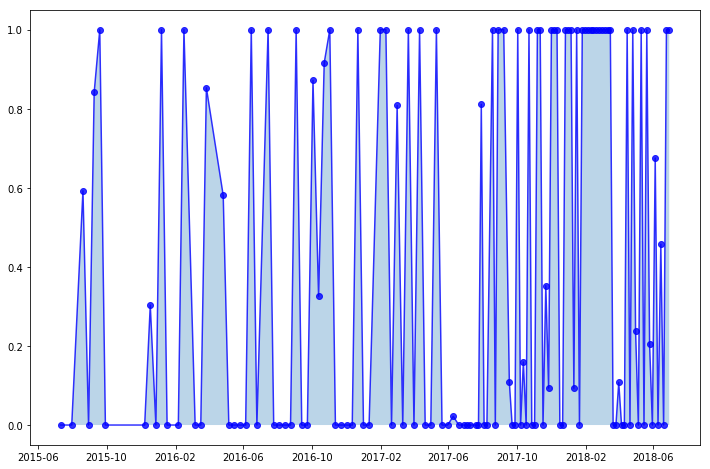

In [17]:
# Izrišemo graf oblačnosti
plt.plot(df["clouds"], linestyle='-', marker='o', color="b", alpha=0.8)
plt.fill_between(df.index, df["clouds"], alpha=0.3)
plt.show()

## Maskiranje podatkov z oblaki

In [18]:
# Izločimo podatke z več kot 10% oblakov
df = df.mask(df["clouds"] >= 0.1)
df.head()

,basicStats.max,basicStats.mean,basicStats.min,basicStats.stDev,clouds
date,,,,,
2018-06-30,NaN,NaN,NaN,NaN,NaN
2018-06-25,NaN,NaN,NaN,NaN,NaN
2018-06-20,0.784255,0.688024,0.363063,0.121820,0.0
2018-06-15,NaN,NaN,NaN,NaN,NaN
2018-06-10,0.774577,0.693728,0.493108,0.049008,0.0


In [19]:
df.describe()

,basicStats.max,basicStats.mean,basicStats.min,basicStats.stDev,clouds
count,66.000000,66.000000,66.000000,66.000000,66.000000
mean,0.631002,0.456045,0.300826,0.091710,0.003161
std,0.226260,0.229767,0.190951,0.066840,0.016285
min,0.037936,0.004727,-0.032019,0.005503,0.000000
25%,0.553032,0.281048,0.145021,0.036145,0.000000
50%,0.715336,0.472477,0.282091,0.063429,0.000000
75%,0.781458,0.675637,0.477146,0.150735,0.000000
max,0.843791,0.819808,0.668443,0.232010,0.093639


In [20]:
# Ustvarimo podatkovni sloj brez oblakov
df_cl = df.dropna()
df_cl.head()

,basicStats.max,basicStats.mean,basicStats.min,basicStats.stDev,clouds
date,,,,,
2018-06-20,0.784255,0.688024,0.363063,0.121820,0.0
2018-06-10,0.774577,0.693728,0.493108,0.049008,0.0
2018-05-31,0.684839,0.450683,0.362460,0.104486,0.0
2018-05-16,0.641694,0.363363,0.241323,0.148087,0.0
2018-05-06,0.769325,0.330141,0.189174,0.194542,0.0


In [23]:
# Število malo oblačnih posnetkov po mesecih
df_cl_m = df_cl["clouds"].groupby([(df_cl.index.year),(df_cl.index.month)]).count()

In [24]:
df_cl_m

date  date
2015  7       2
      8       1
      9       1
      12      2
2016  1       1
      2       1
      3       2
      5       3
      6       2
      7       1
      8       3
      9       2
      11      2
      12      2
2017  1       2
      2       1
      3       1
      4       2
      5       3
      6       3
      7       4
      8       3
      9       2
      10      3
      11      3
      12      2
2018  1       2
      3       2
      4       3
      5       3
      6       2
Name: clouds, dtype: int64

## Graf poteka NDVI

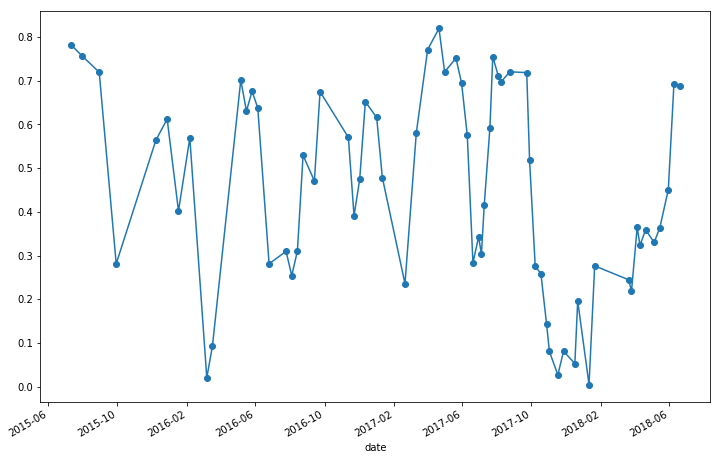

In [25]:
df_cl["basicStats.mean"].plot(linestyle='-', marker='o')

## Analiza podatkov različnih kategorij pokrovnosti

Poglejmo kako se je razvijala vegetacija na različnih površinah. Zanimajo nas:

* travnik,
* njiva,
* voda,
* gozd in
* pozidano.

![](./slike/qgis_vzorci.png)

In [27]:
# WKT različnih območij je v CSV datoteki
vzorci_wkt_fn = "./podatki/vzorci_raba_tal_wkt.csv"
vzorci_wkt = pd.read_csv(vzorci_wkt_fn, sep=";")
vzorci_wkt

,Kategorija,WKT
0,Travnik,POLYGON ((46.232120703379195 14.32473311853502...
1,Njiva,POLYGON ((46.255349134706137 14.34912426611567...
2,Voda,POLYGON ((46.200240459565158 14.40092533384916...
3,Gozd,POLYGON ((46.265696572582584 14.33880147993111...
4,Pozidano,POLYGON ((46.24099737080369 14.354960838786276...


## Časovne vrste posameznih kategorij

Gornji postopek ponovimo za vse kategorije.

In [58]:
kat_ndvi = pd.DataFrame()

In [59]:
for index, row in vzorci_wkt.iterrows():
    print ("Časovna vrsta za razred:", row["Kategorija"])
    geometry = row["WKT"]
    shub_url = shub_url_base + INSTANCE_ID + \
    "?LAYER=NDVI-CLOUDS&STYLE=INDEX&CRS=" +  \
    crs + "&TIME=" + time + "&GEOMETRY=" + geometry + res + maxcc
    r=requests.get(shub_url)
    contents = json.loads(r.content.decode())
    df = json_normalize(contents['C0'])
    df["clouds"] = json_normalize(contents['C1'])["basicStats.mean"]
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df = df.set_index("date")
    df = df.mask(df["clouds"] >= 0.1)
    df_cl = df.dropna()
    df_join = df_cl["basicStats.mean"].copy()
    kat_ndvi[row["Kategorija"]] = df_join

Časovna vrsta za razred: Travnik
Časovna vrsta za razred: Njiva
Časovna vrsta za razred: Voda
Časovna vrsta za razred: Gozd
Časovna vrsta za razred: Pozidano


In [60]:
kat_ndvi.head()

,Travnik,Njiva,Voda,Gozd,Pozidano
date,,,,,
2018-06-30,0.844605,NaN,NaN,NaN,0.168301
2018-06-25,0.142295,NaN,NaN,NaN,NaN
2018-06-20,0.811845,0.696550,-0.106315,0.666350,0.136847
2018-06-15,0.619480,NaN,NaN,NaN,NaN
2018-06-10,0.679110,0.707474,-0.013621,0.653992,0.143682


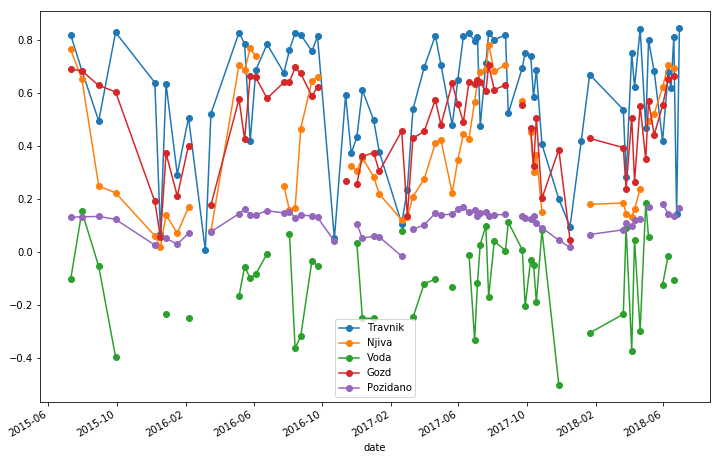

In [61]:
kat_ndvi.plot(marker='o')

## Časovna vrsta za leto 2017

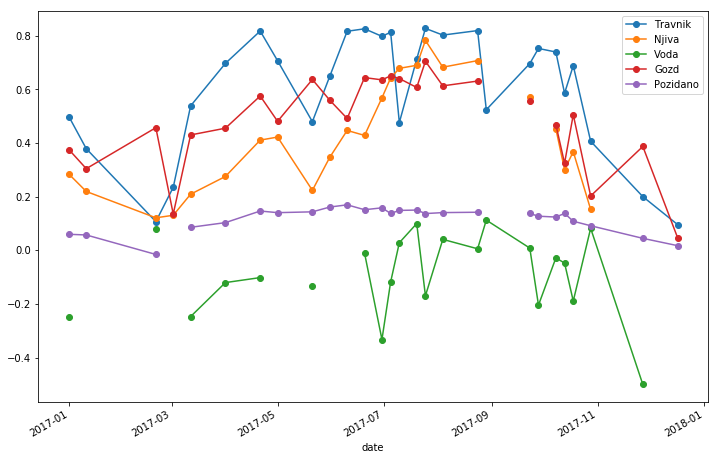

In [83]:
kat_ndvi["2017"].plot(marker='o')

### Njiva

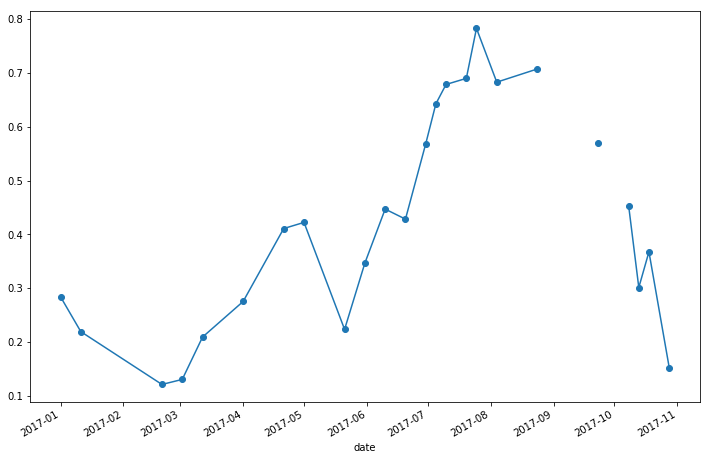

In [86]:
kat_ndvi["2017"]["Njiva"].plot(marker='o')

### Gozd

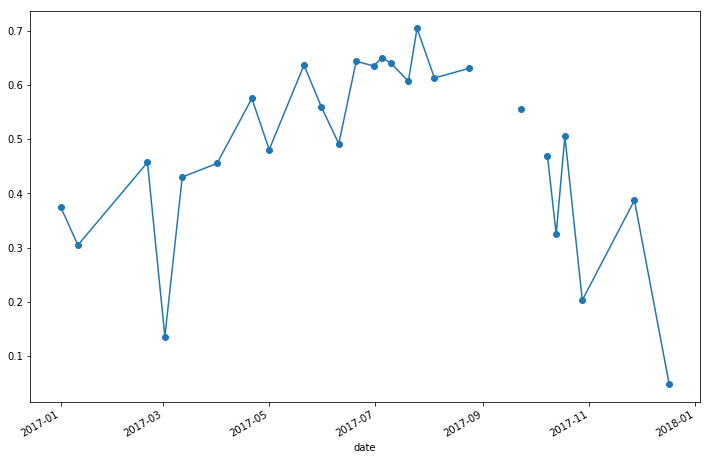

In [87]:
kat_ndvi["2017"]["Gozd"].plot(marker='o')